This is going to be more technical. I'll make a mini-series on practical applications with SQL if you like :) 

### SELECT Statement

```
SELECT [DISTINCT] 
	Tablename1.columnname1,
    Tablename2.columnname3,
    .
    .
    TablenameX.columnnameY,
FROM Tablename1
[LEFT] JOIN Tablename2 
	ON conditions
[LEFT] JOIN Tablename3 
	ON conditions
.
.
[LEFT] JOIN TablenameX
	ON conditions
WHERE 1=1
    AND conditions
[GROUP BY] TablenameN.columnnameM, ...
[HAVING] aggregated conditions
[ORDER BY] TablenameL.columnnameO, ...
[LIMIT] number
```

We have this restauruant loaded from this CSV. We're going to continue building on this.

You can try coding out these problems as we go along

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
pdsql = lambda q: sqldf(q, globals())

# Fetching/Processing Dataset
orders = pd.read_csv('csv/restaurant-1-orders.csv')
orders.columns = ['number', 'timestamp', 'item', 'quantity', 'price', 'total_products_in_cart']
orders['date'] = pd.to_datetime(orders['timestamp'].str[:10])
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart,date
26541,5202,23/04/2017 13:16,Plain Rice,1,2.95,3,2017-04-23
55308,14449,21/04/2019 20:42,Korma - Chicken,1,8.95,5,2019-04-21


In [26]:
print(f"Timeline: {orders['date'].min().date()} to {orders['date'].max().date()}")

Timeline: 2015-01-09 to 2019-12-07


Dates are stored this way because string sorting can also be used

In [108]:
# Fetching/Processing Dataset
products = pd.read_csv('csv/restaurant-1-products-price.csv')
products.columns = ['item', 'price']
products.sample(2)

,item,price
226,King Prawn Shaslick,12.95
171,Chicken Rezala,9.95


## JOIN

**Can we verify if orders.price represents item price or item * quantity price?**

In [109]:
result = pdsql(
"""
SELECT
    orders.*,
    products.price AS product_price
FROM orders
LEFT JOIN products 
    ON products.item=orders.item
""")

In [111]:
result.sample(3)

,number,timestamp,item,quantity,price,total_products_in_cart,date,product_price
30902,14365,16/04/2019 20:54,COBRA (330ML),1,3.95,7,2019-04-16 00:00:00.000000,3.95
8154,8557,17/02/2018 17:42,Plain Papadum,4,0.80,10,2018-02-17 00:00:00.000000,0.80
45052,11454,05/10/2018 21:48,Mixed Starter,1,5.95,5,2018-05-10 00:00:00.000000,5.95


`orders.price` here is the price of a single item.

### SELECT/WHERE

**Which items costed more than \$10?**

In [100]:
result = pdsql(
"""
SELECT DISTINCT 
    item
FROM products
WHERE 1=1
    AND price > 10
""")

In [102]:
print(f"Number of items > $10 = {result.shape[0]}")
result['item'].tolist()[:10]

Number of items > $10 = 42


['Lamb Tikka Biryani',
 'Chicken Tikka Balti',
 'Lamb Tikka Balti',
 'Prawn Biryani',
 'Paneer Tikka Balti',
 'Chicken Tikka Biryani',
 'Persian Lamb Biryani',
 'Prawn Balti',
 'Persian Chicken Biryani',
 'Lamb Persian']

## Aggregations

**How many orders were placed daily in 2019?**

In [53]:
result = pdsql(
"""
SELECT 
    DATE(date) AS date,
    COUNT(DISTINCT number) AS num_orders
FROM orders
WHERE 1=1
    AND date >= '2019-01-01'
    AND date < '2020-01-01'
GROUP BY 1
""")

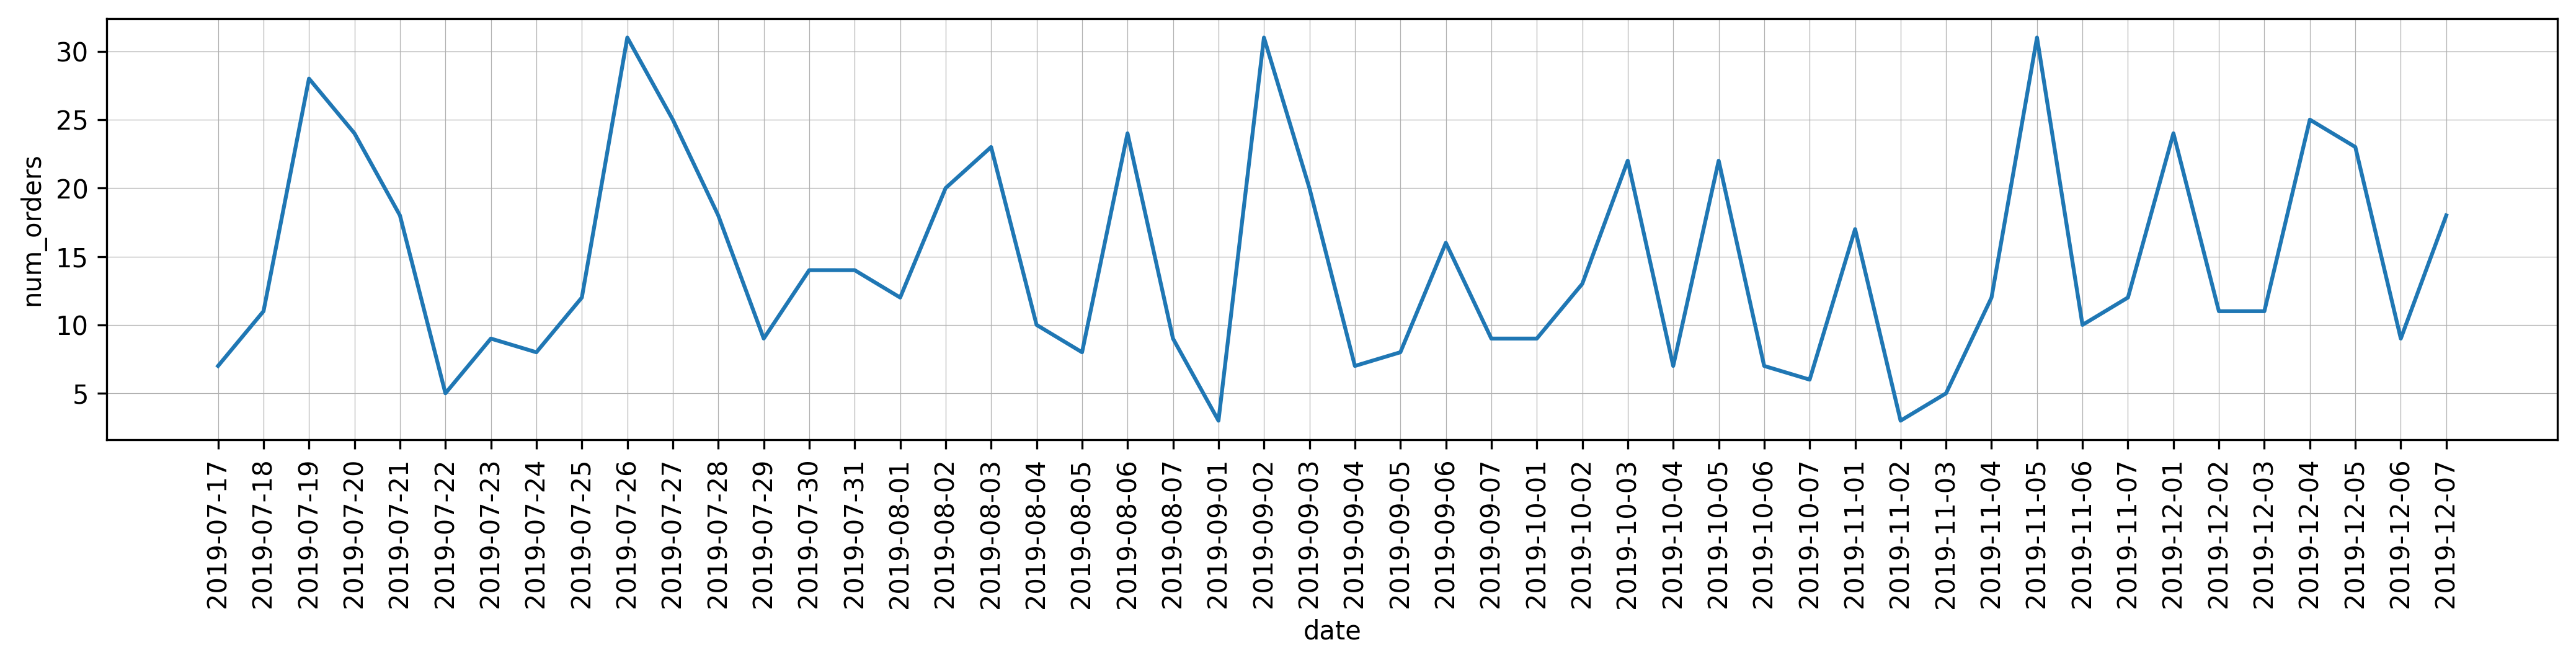

In [54]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=result.tail(50), x='date', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## CASE Statements

Categorize dates in 2019 based on sale counts: 
- high yeild: > 30 sales
- medium yeild: 10-30 sales
- low yeild: <10 sales

In [57]:
result = pdsql(
"""
SELECT 
    date,
    num_orders,
    CASE WHEN num_orders > 30 THEN 'high'
         WHEN num_orders < 10 THEN 'low'
         ELSE 'medium'END AS category
    FROM (
        SELECT 
            DATE(date) AS date,
            COUNT(DISTINCT number) AS num_orders
        FROM orders
        WHERE 1=1
            AND date >= '2019-01-01'
            AND date < '2020-01-01'
        GROUP BY 1
    ) T
""")

In [60]:
result.sample(3)

,date,num_orders,category
77,2019-03-31,22,medium
171,2019-07-23,9,low
108,2019-05-06,9,low


## Common Table Expressions

Better to manage than nesting queries (most of the time)

In [61]:
result = pdsql(
"""
WITH daily_orders AS (
    SELECT 
        DATE(date) AS date,
        COUNT(DISTINCT number) AS num_orders
    FROM orders
    WHERE 1=1
        AND date >= '2019-01-01'
        AND date < '2020-01-01'
    GROUP BY 1
)

SELECT 
    date,
    num_orders,
    CASE WHEN num_orders > 30 THEN 'high'
         WHEN num_orders < 10 THEN 'low'
         ELSE 'medium'END AS category
FROM daily_orders
""")

In [63]:
result.sample(3)

,date,num_orders,category
10,2019-01-15,6,low
90,2019-04-18,11,medium
200,2019-10-07,6,low


## Window Functions

**What were the top 3 most expensive orders every day**?

Let's break this problem down.

Step 1: Get the total price of all orders every day

In [70]:
result = pdsql("""
WITH order_prices AS (
    SELECT 
        DATE(date) AS date,
        number,
        SUM(price) AS total_price
    FROM orders
    WHERE 1=1
        AND date >= '2019-01-01'
        AND date < '2020-01-01'
    GROUP BY 1, 2
)

SELECT * FROM order_prices
""")

In [71]:
result

,date,number,total_price
0,2019-01-01,12766,25.45
1,2019-01-01,12767,37.00
2,2019-01-01,12768,3.95
3,2019-01-01,12769,32.75
4,2019-01-01,12770,31.80
...,...,...,...
3265,2019-12-07,15753,15.85
3266,2019-12-07,15754,32.05
3267,2019-12-07,15755,36.75
3268,2019-12-07,15756,28.80


Step 2: Rank the orders every day from most expensive to least expensive

In [72]:
result = pdsql("""
WITH order_prices AS (
    SELECT 
        DATE(date) AS date,
        number,
        SUM(price) AS total_price
    FROM orders
    WHERE 1=1
        AND date >= '2019-01-01'
        AND date < '2020-01-01'
    GROUP BY 1, 2
)

SELECT
   date,
   number,
   total_price,
   ROW_NUMBER() OVER (PARTITION BY date ORDER BY total_price DESC) AS ranking
FROM order_prices
ORDER BY 1, 4
""")

In [74]:
result.head(20)

,date,number,total_price,ranking
0,2019-01-01,12776,47.55,1
1,2019-01-01,12777,43.40,2
2,2019-01-01,12767,37.00,3
3,2019-01-01,12769,32.75,4
4,2019-01-01,12770,31.80,5
5,2019-01-01,12772,29.60,6
6,2019-01-01,12773,28.45,7
7,2019-01-01,12771,27.80,8
8,2019-01-01,12779,26.75,9
9,2019-01-01,12766,25.45,10


Step 3: Get the top 3 per day

In [76]:
result = pdsql("""
WITH order_prices AS (
    SELECT 
        DATE(date) AS date,
        number,
        SUM(price) AS total_price
    FROM orders
    WHERE 1=1
        AND date >= '2019-01-01'
        AND date < '2020-01-01'
    GROUP BY 1, 2
)

SELECT * 
FROM 
    (SELECT
       date,
       number,
       total_price,
       ROW_NUMBER() OVER (PARTITION BY date ORDER BY total_price DESC) AS ranking
    FROM order_prices
    ORDER BY 1, 4)
WHERE ranking <= 3
""")

In [78]:
result.head(10)

,date,number,total_price,ranking
0,2019-01-01,12776,47.55,1
1,2019-01-01,12777,43.40,2
2,2019-01-01,12767,37.00,3
3,2019-01-02,13192,50.95,1
4,2019-01-02,13184,49.40,2
5,2019-01-02,13185,41.45,3
6,2019-01-03,13606,75.85,1
7,2019-01-03,13632,53.55,2
8,2019-01-03,13613,46.50,3
9,2019-01-04,14127,54.65,1


## Applications

We use these same fundamentals when creating training datasets for these popular problems!
- Time Series Forecasting as a Regression problem: https://github.com/ajhalthor/Time-Series-Forecasting
- Fraud Detection as a Classification problem: https://github.com/ajhalthor/fraud

I'm thinking of making a mini course on getting up to speed with SQL with practical applications. Lemme know your thoughts.